In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
import os
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, roc_auc_score, multilabel_confusion_matrix, precision_score, recall_score
import joblib
from matplotlib import pyplot as plt
import itertools
import seaborn as sns

# 1. Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!unzip "/content/drive/MyDrive/CSC413_Project/MFCC_augmented_last_split.zip"

Streaming output truncated to the last 5000 lines.
 extracting: train/Pine Siskin_160189_seg_38.wav+Marsh Wren_158975_seg_13.wav.png  
 extracting: train/Anna's Hummingbird_159875_seg_3.wav+Pine Siskin_159015_seg_41.wav.png  
 extracting: train/Red-breasted Nuthatch_159321_seg_74.wav+Golden-crowned Sparrow_159724_seg_69.wav.png  
 extracting: train/Bewick's Wren_159376_seg_3.wav+Pine Siskin_160113_seg_8.wav.png  
 extracting: train/Anna's Hummingbird_160046_seg_21.wav+Red-breasted Nuthatch_159329_seg_11.wav.png  
 extracting: train/Pine Siskin_159015_seg_41.wav+Red-breasted Nuthatch_159291_seg_8.wav.png  
 extracting: train/Spotted Towhee_160228_seg_1.wav+Marsh Wren_685677_seg_7.wav.png  
 extracting: train/Song Sparrow_661913_seg_8.wav+Red-winged Blackbird_160102_seg_1.wav.png  
 extracting: train/White-crowned Sparrow_558111_seg_15.wav+Red-breasted Nuthatch_159157_seg_70.wav.png  
 extracting: train/White-crowned Sparrow_160176_seg_28.wav+Spotted Towhee_661084_seg_7.wav.png  
 extrac

In [5]:
class BirdDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.csv_file = f'{data_dir}/{data_dir.split("/")[-1]}.csv'
        self.transform = transform
        self.img_labels, self.label_map = self._get_image_labels_and_map()

    def _get_image_labels_and_map(self):
        # load CSV file
        df = pd.read_csv(self.csv_file)

        # extract filenames and bird names
        img_labels = list(zip(df['filename'], zip(df['label1'], df['label2'])))

        # create a set of unique bird names
        label_set = set(df['label1']).union(set(df['label2']))

        # create a map of bird names to indices
        label_map = {label: idx for idx, label in enumerate(sorted(label_set))}
        print(label_map)

        # convert labels to one-hot encoding
        mlb = MultiLabelBinarizer(classes=sorted(label_set))
        one_hot_encoded_labels = mlb.fit_transform(df[['label1', 'label2']].values)
        one_hot_encoded_labels = [np.array(labels) for labels in one_hot_encoded_labels]

        return list(zip(df['filename'], one_hot_encoded_labels)), label_map

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name, one_hot_labels = self.img_labels[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, one_hot_labels

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # 224x224
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x)) # flatten for NB input
])

In [7]:
def load_data(data_dir, batch_size, transform):
    dataset = BirdDataset(data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [35]:
# Load data
train_data_dir = '/content/train'  # Update this path according to your data location
batch_size = 32
train_dataloader = load_data(train_data_dir, batch_size, transform)

{"Anna's Hummingbird": 0, "Bewick's Wren": 1, 'Golden-crowned Sparrow': 2, 'Marsh Wren': 3, 'Pine Siskin': 4, 'Red-breasted Nuthatch': 5, 'Red-winged Blackbird': 6, 'Song Sparrow': 7, 'Spotted Towhee': 8, 'White-crowned Sparrow': 9}


# 2. Naive Bayes

In [ ]:
# initialize
nb_classifier = MultinomialNB()
multilabel_nb = MultiOutputClassifier(nb_classifier)

In [13]:
# all classes
classes = [np.array([0, 1])] * 10

In [15]:
# train
for images, labels in train_dataloader:
  multilabel_nb.partial_fit(np.array(images), np.array(labels), classes)

In [ ]:
# save model parameters
file_path = '/content/drive/MyDrive/CSC413_Project/nb_parameters.pkl'
joblib.dump(multilabel_nb, file_path)

['/content/drive/MyDrive/CSC413_Project/nb_parameters.pkl']

# 3. Results

In [27]:
# load model parameters
file_path = '/content/drive/MyDrive/CSC413_Project/nb_parameters.pkl'
multilabel_nb = joblib.load(file_path)

In [28]:
# load data
test_data_dir = '/content/test'
test_dataloader = load_data(test_data_dir, 1, transform)

{"Anna's Hummingbird": 0, "Bewick's Wren": 1, 'Golden-crowned Sparrow': 2, 'Marsh Wren': 3, 'Pine Siskin': 4, 'Red-breasted Nuthatch': 5, 'Red-winged Blackbird': 6, 'Song Sparrow': 7, 'Spotted Towhee': 8, 'White-crowned Sparrow': 9}


In [29]:
# retrieve predictions and labels
all_preds, all_labels = [], []
for images, labels in test_dataloader:
  pred = multilabel_nb.predict(np.array(images))
  all_preds.extend(pred)

  all_labels.extend(labels)

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

In [18]:
f1_score(all_labels, all_preds, average='macro')

0.35587695558052257

In [19]:
f1_score(all_labels, all_preds, average='micro')

0.35760983263598334

In [20]:
precision_score(all_labels, all_preds, average='macro')

0.2659599031548802

In [21]:
precision_score(all_labels, all_preds, average='micro')

0.2543949400055809

In [22]:
recall_score(all_labels, all_preds, average='macro')

0.6111386051192846

In [23]:
recall_score(all_labels, all_preds, average='micro')

0.6017601760176018

In [24]:
roc_auc_score(all_labels, all_preds, average='macro')

0.5863793597284875

In [25]:
roc_auc_score(all_labels, all_preds, average='micro')

0.5804180418041804

In [30]:
mcm = multilabel_confusion_matrix(all_labels, all_preds)

In [31]:
mcm

array([[[2340, 1313],
        [ 376,  516]],

       [[1935, 1428],
        [ 496,  686]],

       [[2126, 1676],
        [ 287,  456]],

       [[2363, 1403],
        [ 309,  470]],

       [[2427, 1304],
        [ 304,  510]],

       [[2105, 1301],
        [ 410,  729]],

       [[2248, 1519],
        [ 372,  406]],

       [[2315, 1426],
        [ 330,  474]],

       [[1946, 1348],
        [ 554,  697]],

       [[2222, 1615],
        [ 274,  434]]])

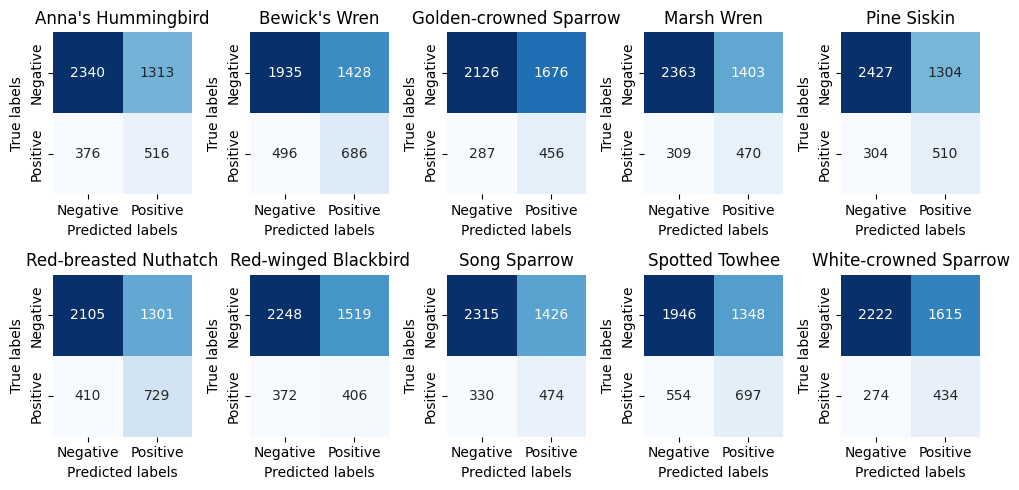

In [34]:
# CONFUSION MATRIX VISUALIZATION
# Define the labels and the confusion matrices
labels = {
    "Anna's Hummingbird": [[2340, 1313],
        [ 376,  516]],
    "Bewick's Wren": [[1935, 1428],
        [ 496,  686]],
    'Golden-crowned Sparrow': [[2126, 1676],
        [ 287,  456]],
    'Marsh Wren': [[2363, 1403],
        [ 309,  470]],
    'Pine Siskin': [[2427, 1304],
        [ 304,  510]],
    'Red-breasted Nuthatch': [[2105, 1301],
        [ 410,  729]],
    'Red-winged Blackbird': [[2248, 1519],
        [ 372,  406]],
    'Song Sparrow': [[2315, 1426],
        [ 330,  474]],
    'Spotted Towhee': [[1946, 1348],
        [ 554,  697]],
    'White-crowned Sparrow': [[2222, 1615],
        [ 274,  434]]
}

# Setting up the figure and axes again for confusion matrices
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.flatten()  # Flatten the grid into a list for easier access

# Plot each confusion matrix again
for i, (bird, matrix) in enumerate(labels.items()):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axs[i], cbar=False)
    axs[i].set_title(f'{bird}')
    axs[i].set_xlabel('Predicted labels')
    axs[i].set_ylabel('True labels')
    axs[i].set_xticklabels(['Negative', 'Positive'])
    axs[i].set_yticklabels(['Negative', 'Positive'])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('/content/nb_cm.pdf', format='pdf', dpi=600)
plt.show()